In [1]:
import tensorflow as tf
from tensorflow import keras

from keras.layers import Conv1D , Dropout , Flatten , MaxPooling1D, Dense, Input, BatchNormalization
from keras.layers.core import Lambda
from keras.models import Model , load_model
from astroNN.gaia import mag_to_fakemag
from astroNN.gaia import fakemag_to_logsol

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import numpy as np
import matplotlib.pyplot as plt
import random
import h5py
from IPython.display import Image

Using TensorFlow backend.


In [2]:
def ApogeeDR14GaiaDR2(dim_t , dim_n): 
    """
    INPUT: 
    dim_t - number of time steps of spectrum 
    dim_n - number of features of spectrum
    """
    
    #SPECTRUM TO LUINOSITY
    dim_1 = 1 # number of corrected magnitude for one example 
    units = 1 #number of final output for one example+
    
    inputs_spectra = Input(shape=(dim_t, dim_n), name="pseudo-lum-input") 
    inputs_mag = Input(shape=(dim_1,), name="K_mag")
    
    x_parallax = Conv1D(filters=2, kernel_size=3, activation='relu')(inputs_spectra)
    x_parallax = BatchNormalization()(x_parallax)
    x_parallax = MaxPooling1D(pool_size=2)(x_parallax)
    
    x_parallax = Conv1D(filters=4, kernel_size=3, activation='relu')(x_parallax)
    x_parallax = BatchNormalization()(x_parallax)
    x_parallax = MaxPooling1D(pool_size=2)(x_parallax)
    
    x_parallax = Flatten()(x_parallax)
    x_parallax = Dense(128, activation='relu')(x_parallax) 
    x_parallax = Dense(64, activation='relu')(x_parallax) 
    x_parallax = Dense(32, activation='relu')(x_parallax)
    x_parallax = Dense(units, activation='softplus', name="pseudo-lum")(x_parallax) 
      
    #OFFSET CORRECTION : (optimization)
    inputs_offset = Input(shape=(3,), name="offset-input")
    x_offset = Dense(64, activation='relu')(inputs_offset)
    x_offset = Dense(32, activation='relu')(x_offset) 
    x_offset = Dense(units, activation='tanh', name="offset")(x_offset) 
    
    #Functions
    outputs_parallax = Lambda(lambda function: tf.math.multiply(function[0], tf.math.pow(10., 
                              tf.math.multiply(-0.2, function[1]))),
                              name='parallax')([x_parallax, inputs_mag])
    
    outputs_parallax_with_offset = Lambda(lambda function: tf.math.add(function[0], function[1]),
                                          name="sum-parallax-offset")([outputs_parallax, x_offset]) 
    
    #Model setup
    model =  Model(inputs = [inputs_spectra,inputs_mag, inputs_offset],outputs = [outputs_parallax_with_offset])
    
    return model 

#### Data load 

In [3]:
# Cargamos los datos
path_local_data = '/home/anell/Desktop/Bovy/AnellExercises/Fits_files'
#path_local_data = '/home/bapanes/Research-Now/local/astronn-local/apo-gaia/'

with h5py.File(f'{path_local_data}/apogeedr14_gaiadr2_with_spectrum_probando_rendimiento_2.h5','r') as F:  
    parallax = np.array(F['parallax'])
    parallax_error = np.array(F['parallax_err'])
    spectra = np.array(F['spectra'])
    Kmag = np.array(F['corrected_magnitude_K'])
    bp_rp = np.array(F['bp_rp'])
    Gmag = np.array(F['phot_g_mean_mag'])
    teff = np.array(F['NN_teff'])
    apogee_id = np.array(F['APOGEE_ID'])
    snr = np.array(F['SNR'])
    fe_h = np.array(F['Fe/H'])
    path_spectra = np.array(F['Path_spectra'])

In [5]:
#filtros que aplica bovy
fakemag, fakemag_error = mag_to_fakemag(Kmag, parallax, parallax_error)
logsol = fakemag_to_logsol(fakemag)


parallax_filtered = parallax[(logsol > 0) | (parallax < 0)]
parallax_error_filtered = parallax_error[(logsol > 0) | (parallax < 0)]
spectra_filtered = spectra[(logsol > 0) | (parallax < 0)]
Kmag_filtered = Kmag[(logsol > 0) | (parallax < 0)]
bp_rp_filtered = bp_rp[(logsol > 0) | (parallax < 0)]
Gmag_filtered = Gmag[(logsol > 0) | (parallax < 0)]
teff_filtered = teff[(logsol > 0) | (parallax < 0)]
snr_filtered = snr[(logsol > 0) | (parallax < 0)]
fe_h_filtered = fe_h[(logsol > 0) | (parallax < 0)]

In [6]:
len(parallax), len(parallax_filtered)

(60986, 46275)

In [7]:
parallax.shape , spectra.shape , Kmag.shape

((60986,), (60986, 7514), (60986,))

In [6]:
#Establecemos las variables que entrarán a la red y corregimos sus dimensiones
X = np.expand_dims(spectra_filtered, axis = 2)
Y = np.expand_dims(parallax_filtered, axis = 1)
K_mag = np.expand_dims(Kmag_filtered, axis = 1)
Y_error = np.expand_dims(parallax_error_filtered, axis = 1)


# Normalizamos Gmag , el color (G_bp - G_rp) y teff
Gmag_std = np.std(Gmag_filtered)
Gmag_mean = np.mean(Gmag_filtered)
Gmag_norm = (Gmag_filtered - Gmag_mean) / Gmag_std

bp_rp_std = np.std(bp_rp_filtered)
bp_rp_mean = np.mean(bp_rp_filtered)
bp_rp_norm = (bp_rp_filtered - bp_rp_mean) / bp_rp_std

teff_std = np.std(teff_filtered)
teff_mean = np.mean(teff_filtered)
teff_norm = (teff_filtered - teff_mean) / teff_std

G_mag = np.expand_dims(Gmag_norm, axis=1)
Bp_Rp = np.expand_dims(bp_rp_norm, axis=1)
Teff = np.expand_dims(teff_norm, axis=1)

X_offset_multivariate = np.concatenate((G_mag, Bp_Rp , Teff), axis = 1)
X_offset_constant = np.ones((Y.shape[0], 3))

In [7]:
print(X.shape , Y.shape, K_mag.shape, X_offset_multivariate.shape , X_offset_constant.shape)

(46275, 7514, 1) (46275, 1) (46275, 1) (46275, 3) (46275, 3)


#### SNR cut

In [8]:
high_snr_idx = []
low_snr_idx = []

for i in range(len(snr_filtered)):
    if snr_filtered[i] >= 200:           
        high_snr_idx.append(i)
    else:
        low_snr_idx.append(i)

random.seed(10)
random.shuffle(high_snr_idx)
random.seed(60)
random.shuffle(low_snr_idx)

In [10]:
print("SNR > 200: %d, else: %d"%(len(high_snr_idx), len(low_snr_idx)))

SNR > 200: 24840, else: 21435


### Diseño Experimental:

Consideraré train (0.8) y valid (0.2)

train_val_1 $\rightarrow$  1000

train_val_2 $\rightarrow$  7000

train_val_3 $\rightarrow$  17840

train_val_4 $\rightarrow$  24840


test $\rightarrow$ 21435

In [11]:
X_high_snr = X[high_snr_idx]
Y_high_snr = Y[high_snr_idx]
Y_error_high_snr = Y_error[high_snr_idx]
K_mag_high_snr = K_mag[high_snr_idx]
X_offset_mult_high_snr = X_offset_multivariate[high_snr_idx]
X_offset_const_high_snr = X_offset_constant[high_snr_idx]


X_low_snr = X[low_snr_idx]
Y_low_snr = Y[low_snr_idx]
Y_error_low_snr = Y_error[low_snr_idx]
K_mag_low_snr = K_mag[low_snr_idx]
X_offset_mult_low_snr = X_offset_multivariate[low_snr_idx]
X_offset_const_low_snr = X_offset_constant[low_snr_idx]

In [12]:
#X_train_val_1 = X_high_snr[:1000]
#Y_train_val_1 = Y_high_snr[:1000]
#K_mag_train_val_1 = K_mag_high_snr[:1000]
#X_offset_train_val_1 = X_offset_high_snr[:1000]

#X_train_val_2 = X_high_snr[1000:9000]
#Y_train_val_2 = Y_high_snr[1000:9000]
#K_mag_train_val_2 = K_mag_high_snr[1000:9000]
#X_offset_train_val_2 = X_offset_high_snr[1000:9000]

#X_train_val_3 = X_high_snr[9000:]
#Y_train_val_3 = Y_high_snr[9000:]
#K_mag_train_val_3 = K_mag_high_snr[9000:]
#X_offset_train_val_3 = X_offset_high_snr[9000:]

X_train_val_4 = X_high_snr
Y_train_val_4 = Y_high_snr
K_mag_train_val_4 = K_mag_high_snr
X_offset_mult_train_val_4 = X_offset_mult_high_snr
X_offset_const_train_val_4 = X_offset_const_high_snr


X_test = X_low_snr
Y_test = Y_low_snr
K_mag_test = K_mag_low_snr
X_offset_mult_test= X_offset_mult_low_snr
X_offset_const_test = X_offset_const_low_snr
snr_test = snr[low_snr_idx]

In [14]:
#print(Y_train_val_1.shape , Y_train_val_2.shape , Y_train_val_3.shape, Y_train_val_4.shape , Y_test.shape)

### Entrenamiento de modelo con offset multivariable

In [18]:
n_timesteps, n_features = X_train_val_4.shape[1], X_train_val_4.shape[2]

Global_model = ApogeeDR14GaiaDR2(n_timesteps , n_features)

Global_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pseudo-lum-input (InputLayer)   (None, 7514, 1)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 7512, 2)      8           pseudo-lum-input[0][0]           
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 7512, 2)      8           conv1d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 3756, 2)      0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [19]:
Global_model.compile(optimizer='adam', loss='mse', metrics=['mse'])

path_local = "/home/anell/Desktop/Bovy/AnellExercises/Good_Models"

earlystopper = EarlyStopping(monitor='val_loss', patience=50, verbose=1, min_delta=1e-7)
checkpoint = ModelCheckpoint(f'{path_local}/Modelo_1_D4_ReplicaBovy_SNR200_mult_logsol.h5', monitor='val_loss', 
                             verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1, patience=5, min_lr=0.000000001)

callbacks=[reduce_lr, checkpoint, earlystopper]

Global_model.fit([X_train_val_4, K_mag_train_val_4, X_offset_mult_train_val_4], Y_train_val_4, callbacks=callbacks,
                 epochs=200, batch_size=128, verbose=1, shuffle="batch", validation_split=0.2)


Train on 19872 samples, validate on 4968 samples
Epoch 1/200
19840/19872 [============================>.] - ETA: 0s - loss: 1.4020 - mse: 1.4020- ETA: 1s - loss: 1.3100

/home/anell/anaconda3/envs/python37-astronn/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_test_batch_begin) is slow compared to the batch update (0.105396). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


19872/19872 [==============================] - 23s 1ms/step - loss: 1.4033 - mse: 1.4033 - val_loss: 2.5859 - val_mse: 2.5859

Epoch 00001: val_loss improved from inf to 2.58589, saving model to /home/anell/Desktop/Bovy/AnellExercises/Good_Models/Modelo_1_D4_ReplicaBovy_SNR200_mult_logsol.h5
Epoch 2/200
19872/19872 [==============================] - 15s 777us/step - loss: 0.9889 - mse: 0.9889 - val_loss: 2.2850 - val_mse: 2.2850

Epoch 00002: val_loss improved from 2.58589 to 2.28498, saving model to /home/anell/Desktop/Bovy/AnellExercises/Good_Models/Modelo_1_D4_ReplicaBovy_SNR200_mult_logsol.h5
Epoch 3/200
19872/19872 [==============================] - 16s 785us/step - loss: 0.7768 - mse: 0.7768 - val_loss: 1.0960 - val_mse: 1.0960

Epoch 00003: val_loss improved from 2.28498 to 1.09599, saving model to /home/anell/Desktop/Bovy/AnellExercises/Good_Models/Modelo_1_D4_ReplicaBovy_SNR200_mult_logsol.h5
Epoch 4/200
19872/19872 [==============================] - 16s 821us/step - loss: 0.5


Epoch 00032: val_loss improved from 0.06156 to 0.06039, saving model to /home/anell/Desktop/Bovy/AnellExercises/Good_Models/Modelo_1_D4_ReplicaBovy_SNR200_mult_logsol.h5
Epoch 33/200
19872/19872 [==============================] - 16s 822us/step - loss: 0.0310 - mse: 0.0310 - val_loss: 0.0629 - val_mse: 0.0629

Epoch 00033: val_loss did not improve from 0.06039
Epoch 34/200
19872/19872 [==============================] - 16s 812us/step - loss: 0.0308 - mse: 0.0308 - val_loss: 0.0613 - val_mse: 0.0613

Epoch 00034: val_loss did not improve from 0.06039
Epoch 35/200
19872/19872 [==============================] - 16s 811us/step - loss: 0.0298 - mse: 0.0298 - val_loss: 0.0589 - val_mse: 0.0589

Epoch 00035: val_loss improved from 0.06039 to 0.05891, saving model to /home/anell/Desktop/Bovy/AnellExercises/Good_Models/Modelo_1_D4_ReplicaBovy_SNR200_mult_logsol.h5
Epoch 36/200
19872/19872 [==============================] - 16s 811us/step - loss: 0.0310 - mse: 0.0310 - val_loss: 0.0566 - val_ms

19872/19872 [==============================] - 16s 786us/step - loss: 0.0163 - mse: 0.0163 - val_loss: 0.0534 - val_mse: 0.0534

Epoch 00105: val_loss did not improve from 0.05311
Epoch 106/200
19872/19872 [==============================] - 16s 789us/step - loss: 0.0163 - mse: 0.0163 - val_loss: 0.0533 - val_mse: 0.0533

Epoch 00106: val_loss did not improve from 0.05311
Epoch 107/200
19872/19872 [==============================] - 16s 786us/step - loss: 0.0163 - mse: 0.0163 - val_loss: 0.0534 - val_mse: 0.0534

Epoch 00107: val_loss did not improve from 0.05311
Epoch 108/200
19872/19872 [==============================] - 16s 784us/step - loss: 0.0163 - mse: 0.0163 - val_loss: 0.0535 - val_mse: 0.0535

Epoch 00108: val_loss did not improve from 0.05311
Epoch 109/200
19872/19872 [==============================] - 16s 787us/step - loss: 0.0163 - mse: 0.0163 - val_loss: 0.0534 - val_mse: 0.0534

Epoch 00109: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.

Epoch 00109: 

#### simple evaluations on test sample (SNR < 200)

In [20]:
pred = Global_model.predict([X_test, K_mag_test , X_offset_mult_test])

In [21]:
target = Y_test

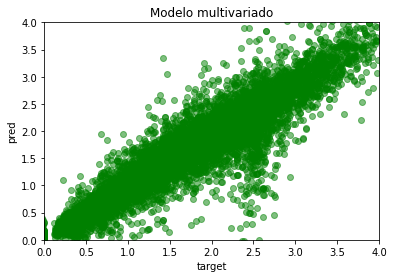

In [35]:
plt.scatter(target, pred, c="g", alpha=0.5)

plt.xlabel("target")
plt.ylabel("pred")
plt.title("Modelo multivariado")

plt.ylim(0,4)
plt.xlim(0,4)
plt.show()

### Entrenamiento de modelo con offset constante

In [29]:
n_timesteps, n_features = X_train_val_4.shape[1], X_train_val_4.shape[2]

Global_model_constant = ApogeeDR14GaiaDR2(n_timesteps , n_features)

Global_model_constant.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pseudo-lum-input (InputLayer)   (None, 7514, 1)      0                                            
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 7512, 2)      8           pseudo-lum-input[0][0]           
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 7512, 2)      8           conv1d_5[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_5 (MaxPooling1D)  (None, 3756, 2)      0           batch_normalization_5[0][0]      
____________________________________________________________________________________________

In [30]:
Global_model_constant.compile(optimizer='adam', loss='mse', metrics=['mse'])

path_local = "/home/anell/Desktop/Bovy/AnellExercises/Good_Models"

earlystopper = EarlyStopping(monitor='val_loss', patience=50, verbose=1, min_delta=1e-7)
checkpoint = ModelCheckpoint(f'{path_local}/Modelo_1_D4_ReplicaBovy_SNR200_const_logsol.h5', monitor='val_loss', 
                             verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1, patience=5, min_lr=0.000000001)

callbacks=[reduce_lr, checkpoint, earlystopper]

Global_model_constant.fit([X_train_val_4, K_mag_train_val_4, X_offset_const_train_val_4], Y_train_val_4, callbacks=callbacks,
                 epochs=200, batch_size=128, verbose=1, shuffle="batch", validation_split=0.2)


Train on 19872 samples, validate on 4968 samples
Epoch 1/200
19872/19872 [==============================] - 16s 798us/step - loss: 1.2903 - mse: 1.2903 - val_loss: 2.3656 - val_mse: 2.3656

Epoch 00001: val_loss improved from inf to 2.36561, saving model to /home/anell/Desktop/Bovy/AnellExercises/Good_Models/Modelo_1_D4_ReplicaBovy_SNR200_const_logsol.h5
Epoch 2/200
19872/19872 [==============================] - 16s 812us/step - loss: 1.7228 - mse: 1.7228 - val_loss: 2.6064 - val_mse: 2.6064

Epoch 00002: val_loss did not improve from 2.36561
Epoch 3/200
19872/19872 [==============================] - 16s 806us/step - loss: 0.8972 - mse: 0.8972 - val_loss: 2.5661 - val_mse: 2.5661

Epoch 00003: val_loss did not improve from 2.36561
Epoch 4/200
19872/19872 [==============================] - 16s 823us/step - loss: 0.3172 - mse: 0.3172 - val_loss: 0.3090 - val_mse: 0.3090

Epoch 00004: val_loss improved from 2.36561 to 0.30905, saving model to /home/anell/Desktop/Bovy/AnellExercises/Good_M

19872/19872 [==============================] - 16s 787us/step - loss: 0.0313 - mse: 0.0313 - val_loss: 0.0957 - val_mse: 0.0957

Epoch 00037: val_loss improved from 0.09986 to 0.09567, saving model to /home/anell/Desktop/Bovy/AnellExercises/Good_Models/Modelo_1_D4_ReplicaBovy_SNR200_const_logsol.h5
Epoch 38/200
19872/19872 [==============================] - 16s 800us/step - loss: 0.0315 - mse: 0.0315 - val_loss: 0.0950 - val_mse: 0.0950

Epoch 00038: val_loss improved from 0.09567 to 0.09501, saving model to /home/anell/Desktop/Bovy/AnellExercises/Good_Models/Modelo_1_D4_ReplicaBovy_SNR200_const_logsol.h5
Epoch 39/200
19872/19872 [==============================] - 16s 787us/step - loss: 0.0308 - mse: 0.0308 - val_loss: 0.0933 - val_mse: 0.0933

Epoch 00039: val_loss improved from 0.09501 to 0.09334, saving model to /home/anell/Desktop/Bovy/AnellExercises/Good_Models/Modelo_1_D4_ReplicaBovy_SNR200_const_logsol.h5
Epoch 40/200
19872/19872 [==============================] - 16s 790us/step

19872/19872 [==============================] - 16s 789us/step - loss: 0.0193 - mse: 0.0193 - val_loss: 0.0870 - val_mse: 0.0870

Epoch 00071: val_loss improved from 0.08746 to 0.08696, saving model to /home/anell/Desktop/Bovy/AnellExercises/Good_Models/Modelo_1_D4_ReplicaBovy_SNR200_const_logsol.h5
Epoch 72/200
19872/19872 [==============================] - 16s 794us/step - loss: 0.0192 - mse: 0.0192 - val_loss: 0.0867 - val_mse: 0.0867

Epoch 00072: val_loss improved from 0.08696 to 0.08668, saving model to /home/anell/Desktop/Bovy/AnellExercises/Good_Models/Modelo_1_D4_ReplicaBovy_SNR200_const_logsol.h5
Epoch 73/200
19872/19872 [==============================] - 16s 787us/step - loss: 0.0192 - mse: 0.0192 - val_loss: 0.0897 - val_mse: 0.0897

Epoch 00073: val_loss did not improve from 0.08668
Epoch 74/200
19872/19872 [==============================] - 16s 786us/step - loss: 0.0191 - mse: 0.0191 - val_loss: 0.0875 - val_mse: 0.0875

Epoch 00074: val_loss did not improve from 0.08668
E

19872/19872 [==============================] - 16s 799us/step - loss: 0.0153 - mse: 0.0153 - val_loss: 0.0835 - val_mse: 0.0835

Epoch 00107: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00107: val_loss did not improve from 0.08297
Epoch 108/200
19872/19872 [==============================] - 18s 892us/step - loss: 0.0152 - mse: 0.0152 - val_loss: 0.0828 - val_mse: 0.0828

Epoch 00108: val_loss improved from 0.08297 to 0.08284, saving model to /home/anell/Desktop/Bovy/AnellExercises/Good_Models/Modelo_1_D4_ReplicaBovy_SNR200_const_logsol.h5
Epoch 109/200
19872/19872 [==============================] - 16s 802us/step - loss: 0.0152 - mse: 0.0152 - val_loss: 0.0840 - val_mse: 0.0840

Epoch 00109: val_loss did not improve from 0.08284
Epoch 110/200
19872/19872 [==============================] - 16s 805us/step - loss: 0.0151 - mse: 0.0151 - val_loss: 0.0842 - val_mse: 0.0842

Epoch 00110: val_loss did not improve from 0.08284
Epoch 111/200
19872/19872 [==========

In [38]:
pred_const = Global_model_constant.predict([X_test, K_mag_test , X_offset_const_test])

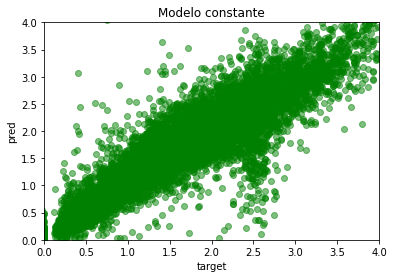

In [39]:
plt.scatter(target, pred_const, c="g", alpha=0.5)

plt.xlabel("target")
plt.ylabel("pred")
plt.title("Modelo constante")

plt.ylim(0,4)
plt.xlim(0,4)
plt.show()

### Carga de modelos y grafico de distancias (kpc)

In [13]:
path_local = "/home/anell/Desktop/Bovy/AnellExercises/Good_Models"
model_mult = load_model(f'{path_local}/Modelo_1_D4_ReplicaBovy_SNR200_mult_logsol.h5', custom_objects = {'tf':tf})
model_const = load_model(f'{path_local}/Modelo_1_D4_ReplicaBovy_SNR200_const_logsol.h5', custom_objects = {'tf':tf})

In [15]:
parallax_mult_layer = Model(input = model_mult.input , output = model_mult.get_layer('parallax').output) 
parallax_mult_output = parallax_mult_layer.predict([X_test, K_mag_test , X_offset_mult_test])

parallax_const_layer = Model(input = model_const.input , output = model_const.get_layer('parallax').output) 
parallax_const_output = parallax_const_layer.predict([X_test, K_mag_test , X_offset_const_test])

/home/anell/anaconda3/envs/python37-astronn/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("pa...)`
  """Entry point for launching an IPython kernel.
/home/anell/anaconda3/envs/python37-astronn/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("pa...)`
  after removing the cwd from sys.path.


In [32]:
#otro filtro que agrega bovy
low_error = Y_test / Y_error_low_snr > 5 
parallax_mult_output = parallax_mult_output[low_error]
parallax_cont_output = parallax_const_output[low_error]

In [39]:
dist_mult = 1 / parallax_mult_output
dist_const = 1 / parallax_cont_output

target = 1 / Y_test[low_error]

/home/anell/anaconda3/envs/python37-astronn/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/anell/anaconda3/envs/python37-astronn/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


In [40]:
len(dist_mult), len(target)

(20813, 20813)

In [41]:
len(dist_const)

20813

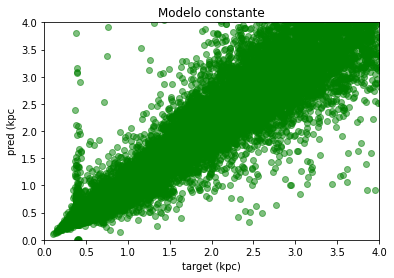

In [44]:
plt.scatter(target, dist_const, c="g", alpha=0.5)

plt.xlabel("target (kpc)")
plt.ylabel("pred (kpc")
plt.title("Modelo constante")

plt.ylim(0,4)
plt.xlim(0,4)
plt.show()

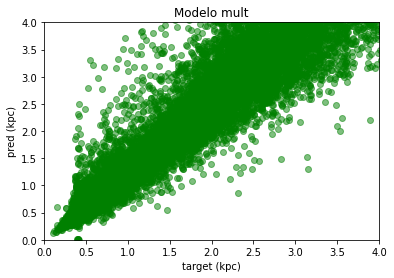

In [45]:
plt.scatter(target, dist_mult, c="g", alpha=0.5)

plt.xlabel("target (kpc)")
plt.ylabel("pred (kpc)")
plt.title("Modelo mult")

plt.ylim(0,4)
plt.xlim(0,4)
plt.show()

### Obtención de offset de cada modelo

In [16]:
offset_mult_layer = Model(input = model_mult.input , output = model_mult.get_layer('offset').output) 
offset_mult_output = offset_mult_layer.predict([X_test, K_mag_test , X_offset_mult_test])

offset_const_layer = Model(input = model_const.input , output = model_const.get_layer('offset').output) 
offset_const_output = offset_const_layer.predict([X_test, K_mag_test , X_offset_const_test])

/home/anell/anaconda3/envs/python37-astronn/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("of...)`
  """Entry point for launching an IPython kernel.
/home/anell/anaconda3/envs/python37-astronn/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("of...)`
  after removing the cwd from sys.path.


In [17]:
np.mean(offset_mult_output) , np.mean(offset_const_output)

(0.15736352, 0.0394991)

In [18]:
np.median(offset_mult_output)

0.11629968

In [19]:
offset_const_output[:10]

array([[0.0394991],
       [0.0394991],
       [0.0394991],
       [0.0394991],
       [0.0394991],
       [0.0394991],
       [0.0394991],
       [0.0394991],
       [0.0394991],
       [0.0394991]], dtype=float32)